*   AI Hub의 과적차량 도로 위험 데이터의 샘플 데이터를 다운로드, 과적 차량과 정상 차량의 데이터 각 170개를 140, 30개씩 나누어 학습과 검증에 사용하였습니다.

*   다운로드한 데이터는 다음 이미지와 같은 경로로 구글 드라이브에 저장 후 사용하였습니다.

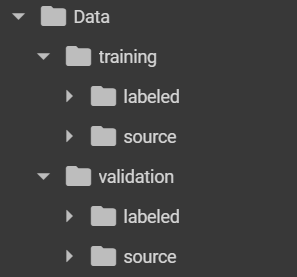



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Detectron2 설치**

In [2]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core

!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 5.3 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15730, done.
remote: Counting objects: 100% (453/453), done.
remote: Compressing objects: 100% (332/332), done.
remote: Total 15730 (delta 206), reused 301 (delta 112), pack-reused 15277
Receiving objects: 100% (15730/15730), 6.51 MiB | 19.11 MiB/s, done.
Resolving deltas: 100% (11322/11322), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.6 MB/s eta 0:0

In [3]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.3 ; cuda:  cu121
detectron2: 0.6


In [4]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# **데이터 변환**

In [5]:
from detectron2.structures import BoxMode

def convert_json_files(json_dir, image_dir, images, annotations, start_image_id, start_annotation_id):
    current_image_id = start_image_id
    current_annotation_id = start_annotation_id

    for json_file in os.listdir(json_dir):
        if json_file.endswith(".json"):
            json_path = os.path.join(json_dir, json_file)
            with open(json_path) as f:
                data = json.load(f)

            for entry in data["FILE"]:
                file_name = entry["FILE_NAME"]
                file_path = os.path.join(image_dir, file_name)
                if not os.path.exists(file_path):
                    continue

                # Read image size
                height, width = cv2.imread(file_path).shape[:2]

                # Append image info
                images.append({
                    "file_name": file_path,
                    "height": height,
                    "width": width,
                    "id": current_image_id
                })

                for item in entry["ITEMS"]:
                    if item["DRAWING"] == "Box":
                        bbox = list(map(float, item["BOX"].split(',')))
                        xmin, ymin, width, height = bbox[0], bbox[1], bbox[2], bbox[3]

                        # Determine class based on "CLASS" field
                        class_name = item["CLASS"]
                        if class_name == "적재불량":
                            category_id = 1
                        elif class_name == "정상차량":
                            category_id = 0
                        else:
                            continue  # Ignore entries that are not classified as "적재불량" or "정상차량"

                        # Append annotation info
                        annotations.append({
                            "bbox": [xmin, ymin, width, height],
                            "bbox_mode": BoxMode.XYWH_ABS,
                            "category_id": category_id,
                            "image_id": current_image_id,
                            "id": current_annotation_id,
                            "segmentation": [],
                            "area": width * height,
                            "iscrowd": 0
                        })
                        current_annotation_id += 1

                current_image_id += 1

    return current_image_id, current_annotation_id

def merge_json_files(training=True):
    base_dir = "/content/drive/MyDrive/Data/training" if training else "/content/drive/MyDrive/Data/validation" # 데이터 경로 지정 필요

    merged_data = {
        "images": [],
        "annotations": [],
        "categories": [
            {"id": 0, "name": "normal_vehicle"},  # 정상 차량
            {"id": 1, "name": "overloaded_vehicle"}  # 적재불량 차량
        ]
    }

    current_image_id = 0
    current_annotation_id = 0

    json_dir = os.path.join(base_dir, "labeled")
    image_dir = os.path.join(base_dir, "source")

    current_image_id, current_annotation_id = convert_json_files(
        json_dir, image_dir,
        merged_data["images"], merged_data["annotations"],
        current_image_id, current_annotation_id
    )

    output_file = "merged_training_annotations.json" if training else "merged_validation_annotations.json"
    with open(output_file, 'w') as f:
        json.dump(merged_data, f, indent=4)

# Training 데이터셋 병합 및 변환
merge_json_files(training=True)

# Validation 데이터셋 병합 및 변환
merge_json_files(training=False)

In [6]:
from detectron2.data.datasets import register_coco_instances

# 파일 경로 설정
training_json = "merged_training_annotations.json"
validation_json = "merged_validation_annotations.json"
image_dir = "/content/drive/MyDrive/Data"  # 경로 지정 필요

# 데이터셋 등록
register_coco_instances("vehicle_train", {}, training_json, image_dir)
register_coco_instances("vehicle_val", {}, validation_json, image_dir)

# 메타데이터 가져오기
train_metadata = MetadataCatalog.get("vehicle_train")
val_metadata = MetadataCatalog.get("vehicle_val")

print("Train Dataset Metadata:", train_metadata)
print("Validation Dataset Metadata:", val_metadata)

Train Dataset Metadata: Metadata(name='vehicle_train', json_file='merged_training_annotations.json', image_root='/content/drive/MyDrive/Data', evaluator_type='coco')
Validation Dataset Metadata: Metadata(name='vehicle_val', json_file='merged_validation_annotations.json', image_root='/content/drive/MyDrive/Data', evaluator_type='coco')


WARNING [06/15 08:03:21 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/15 08:03:21 d2.data.datasets.coco]: Loaded 280 images in COCO format from merged_training_annotations.json


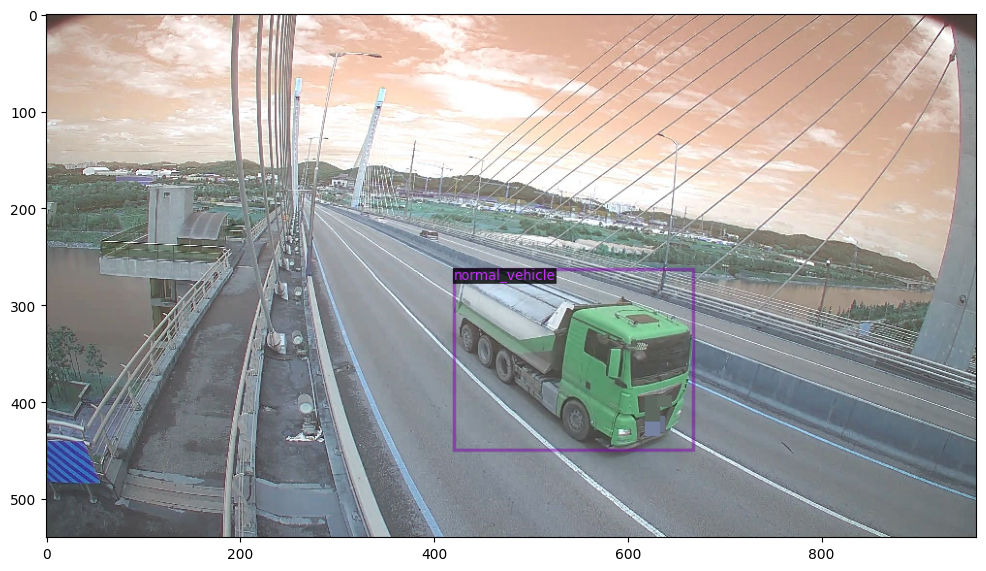

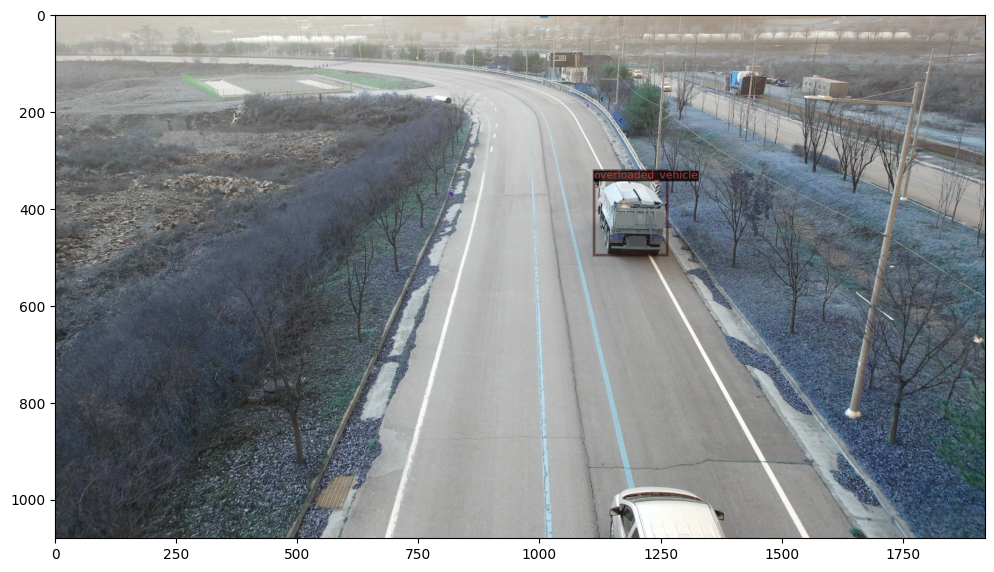

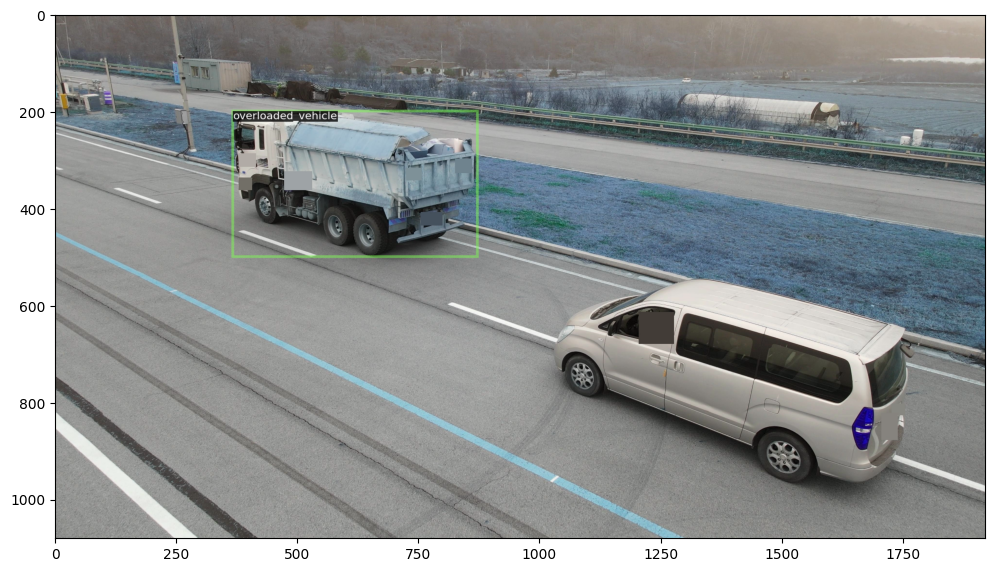

In [7]:
import matplotlib.pyplot as plt

# training 데이터셋 시각화
train_dataset_dicts = DatasetCatalog.get("vehicle_train")
for d in random.sample(train_dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=(12, 8))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

AI Hub에서 다운로드한 데이터를 detectron2에서 요구하는 형식으로 전환, 등록 후 시각화

# **학습 수행**

In [8]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("vehicle_train",)
cfg.DATASETS.TEST = ("vehicle_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # 사전 학습된 모델 사용
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000  # 학습 반복 횟수 조정
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # 두 가지 클래스: 정상차량과 적재불량 차량

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[06/15 08:04:07 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:00, 199MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[06/15 08:04:08 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[06/15 08:04:25 d2.utils.events]:  eta: 0:09:03  iter: 19  total_loss: 1.566  loss_cls: 1.087  loss_box_reg: 0.4239  loss_rpn_cls: 0.026  loss_rpn_loc: 0.001729    time: 0.6125  last_time: 0.5949  data_time: 0.1405  last_data_time: 0.1795   lr: 4.9953e-06  max_mem: 2549M
[06/15 08:04:41 d2.utils.events]:  eta: 0:08:45  iter: 39  total_loss: 1.396  loss_cls: 1.002  loss_box_reg: 0.3936  loss_rpn_cls: 0.02067  loss_rpn_loc: 0.001339    time: 0.6085  last_time: 0.5047  data_time: 0.1236  last_data_time: 0.0314   lr: 9.9902e-06  max_mem: 2549M
[06/15 08:04:53 d2.utils.events]:  eta: 0:08:43  iter: 59  total_loss: 1.27  loss_cls: 0.8364  loss_box_reg: 0.4079  loss_rpn_cls: 0.01664  loss_rpn_loc: 0.001607    time: 0.6076  last_time: 0.5228  data_time: 0.1134  last_data_time: 0.0109   lr: 1.4985e-05  max_mem: 2549M
[06/15 08:05:07 d2.utils.events]:  eta: 0:08:41  iter: 79  total_loss: 1.078  loss_cls: 0.6678  loss_box_reg: 0.4309  loss_rpn_cls: 0.01638  loss_rpn_loc: 0.001796    time: 0.6256 

# **성능 평가**

In [9]:
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # "적재불량 차량"과 "정상 차량" 두 가지 클래스
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # 학습된 모델 가중치
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # 테스트 시 사용할 confidence threshold

predictor = DefaultPredictor(cfg)

# 이미지에 대해 추론 수행
def perform_inference(image_path, predictor, metadata):
    if not os.path.isfile(image_path):
        print(f"Error: File {image_path} does not exist.")
        return

    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Failed to load image {image_path}.")
        return

    outputs = predictor(img)

    v = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5, instance_mode=ColorMode.IMAGE_BW)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    plt.figure(figsize=(14, 10))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.show()

# 테스트 이미지 경로 설정
test_image_path = "/content/drive/MyDrive/Data/validation/source"  # 경로 지정 필요
perform_inference(test_image_path, predictor, MetadataCatalog.get("vehicle_train"))

# 평가를 위한 데이터 로더 및 평가자 초기화
evaluator = COCOEvaluator("vehicle_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "vehicle_val")

# 모델 성능 평가.
evaluation_results = inference_on_dataset(predictor.model, val_loader, evaluator)
print(evaluation_results)

[06/15 08:14:58 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
Error: File /content/drive/MyDrive/Data/validation/source does not exist.
[06/15 08:14:58 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [06/15 08:14:58 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/15 08:14:58 d2.data.datasets.coco]: Loaded 60 images in COCO format from merged_validation_annotations.json
[06/15 08:14:58 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/15 08:14:58 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/15 08:14:58 d2.data.common]: Serializing 60 elements to byte tensors and concatenating them all ...
[06/15 08:14:58 d2.data.common]: Serialized

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[06/15 08:15:01 d2.evaluation.evaluator]: Inference done 11/60. Dataloading: 0.0033 s/iter. Inference: 0.1142 s/iter. Eval: 0.0003 s/iter. Total: 0.1179 s/iter. ETA=0:00:05
[06/15 08:15:06 d2.evaluation.evaluator]: Inference done 37/60. Dataloading: 0.0562 s/iter. Inference: 0.1254 s/iter. Eval: 0.0003 s/iter. Total: 0.1822 s/iter. ETA=0:00:04
[06/15 08:15:11 d2.evaluation.evaluator]: Inference done 54/60. Dataloading: 0.0934 s/iter. Inference: 0.1329 s/iter. Eval: 0.0010 s/iter. Total: 0.2277 s/iter. ETA=0:00:01
[06/15 08:15:12 d2.evaluation.evaluator]: Total inference time: 0:00:12.306567 (0.223756 s / iter per device, on 1 devices)
[06/15 08:15:12 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:07 (0.132234 s / iter per device, on 1 devices)
[06/15 08:15:12 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/15 08:15:12 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[06/15 08:15:12 d2.evaluation.coco_eva